In [1]:
import os
import string
from collections import OrderedDict
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable


cuda = True if torch.cuda.is_available() else False
print("Is cuda enabled?", "YES" if cuda else "NO")

Is cuda enabled? YES


In [2]:
REBUILD_DATA = False

IMG_SIZE = 32
FOLDER_PATH = "../../Data/Letters/"
CLASSES = os.listdir(FOLDER_PATH)
LABEL_COUNT = len(CLASSES)
LABELS = dict(zip(CLASSES, np.arange(LABEL_COUNT)))

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


class DogsVSCats():
    classes_counts = dict(zip(CLASSES, np.zeros(LABEL_COUNT, dtype="int32")))
    training_data = []
    
    def make_training_data(self):
        for label in LABELS:
            print(label, end=" ")
            for f in os.listdir(FOLDER_PATH + label):
                path = os.path.join(FOLDER_PATH + label, f)
                img = rgb2gray(plt.imread(path))
                self.training_data.append([img, np.eye(LABEL_COUNT)[LABELS[label]]])
                self.classes_counts[label] += 1
        self.training_data = np.array(self.training_data, dtype=object)
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)       
        

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()
    print("\n", dogsvscats.classes_counts)

training_data = np.load("training_data.npy", allow_pickle=True)
print(f"\ntraining_data.shape = {training_data.shape}")


training_data.shape = (7436, 2)


In [4]:
training_data[0]

array([array([[254.9745, 254.9745, 254.9745, ..., 251.9748, 254.9745, 249.975 ],
              [248.9751, 249.975 , 254.9745, ..., 251.9748, 254.9745, 254.9745],
              [254.9745, 254.9745, 248.9751, ..., 254.9745, 246.9753, 242.9757],
              ...,
              [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
              [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745],
              [254.9745, 254.9745, 254.9745, ..., 254.9745, 254.9745, 254.9745]]),
       array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0.])                               ],
      dtype=object)

['O', 'W', 'O', 'F', 'F', 'K', 'D', 'P', 'X', 'R']

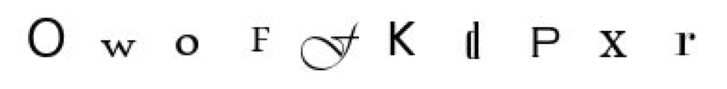

In [5]:
n_examples = 10

plt.rcParams['figure.dpi'] =  150
rng = np.random.default_rng()
ex_ind = rng.integers(low=0, high=training_data.shape[0], size=n_examples)

fig, ax = plt.subplots(1,n_examples)

for i, ind in enumerate(ex_ind):
    ax[i].imshow(training_data[ind][0], cmap="gray")
    ax[i].axis("off")
[CLASSES[np.where(training_data[i][1])[0][0]].upper() for i in ex_ind]

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, 1, 2)
        
        self._out_dim = 128 * int(np.floor(IMG_SIZE / 2 ** 3) ** 2)
        # 128 - n-channels; IMG_SIZE - input dim; 2 - pool dim; 3 - k-pools; 2 - an image is like a square
        
        self.fc1 = nn.Linear(self._out_dim, 512)
        self.fc2 = nn.Linear(512, 26)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        
        x = x.view(-1, self._out_dim)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [7]:
net = Net()
net._out_dim

2048

In [8]:
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_function = nn.MSELoss()

training_data = training_data / 128.0 - 1
X = torch.Tensor([i[0] for i in training_data]).view(-1, IMG_SIZE, IMG_SIZE)
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
print(f"Validation size: {val_size}")

Validation size: 743


In [9]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(f"len(train_X) = {len(train_X)}")
print(f"len(test_X) = {len(test_X)}")

len(train_X) = 6693
len(test_X) = 743


In [39]:
BATCH_SIZE = 60
EPOCHS = 10

loss_log = []
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i:i + BATCH_SIZE].view(-1, 1, IMG_SIZE, IMG_SIZE)
        batch_y = train_y[i:i + BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
print(loss.item())

 68%|██████████████████████████████████████████████████████▉                          | 76/112 [00:04<00:02, 16.25it/s]


KeyboardInterrupt: 

In [35]:
print(len(torch.argmax(outputs, dim=1)))

26

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, IMG_SIZE, IMG_SIZE))
        predicted_class = torch.argmax(net_out)
#         print(f"Top net_outs: {net_out.sort()[:5]}")
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy:", round(correct/total, 3) * 100)

100%|██████████████████████████████████████████████████████████████████████████████| 743/743 [00:00<00:00, 1190.35it/s]

Accuracy: 89.1


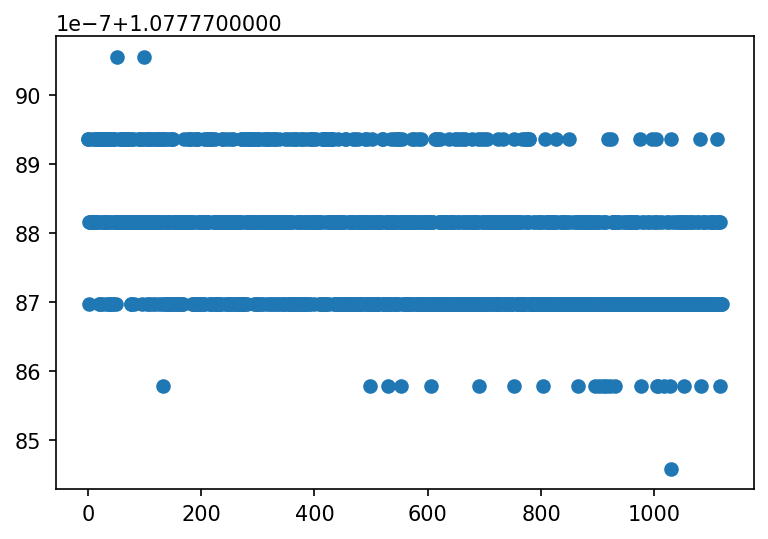

In [23]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(loss_log)), loss_log)
